In [1]:
import os
import gc  #This is garbage collector 
import sys #System 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
        
# from sklearn.preprocessing import StandardScaler as scale
# from sklearn.decomposition import PCA
# from sklearn.cluster import k_means


from random import seed
from random import randint
seed(1)


from matplotlib import pyplot as plt

In [7]:
def read_data():
    df = pd.read_csv("Inputs/train.csv")
    return df 

def convert_to_pickle(df, loc_with_name):
    with open(loc_with_name, 'wb') as fp:
        pickle.dump(df, fp)

def read_pickle(loc_with_name):
    with open (loc_with_name, 'rb') as fp:
        df = pickle.load(fp)
    return df 

def preprocess(df):
    #Dataset length 
    org_len = len(df)

    #Saving memory by changing the dtype
    for i in df:
        if df[i].dtype == np.float64:
            if (((df[i] < .0001) & (df[i] > -.0001)).mean()) < .001:
                df[i] = df[i].astype(np.float32)
                gc.collect()

    #Changing the data types 
    df.date = df.date.astype(np.int16)
    df.ts_id = df.ts_id.astype(np.int32)
    df.feature_0 = df.feature_0.astype(np.int32)

    #Sorting with respect to date
    df.sort_values(by = ['date','ts_id'],inplace = True)

    #Create a action column - 1 if the resp is >0 and 0 if resp < 0 
    df['action'] = np.where(df['resp'] > 0 , 1 , 0 )
    df.action = df.action.astype("category")
    
    return df


def return_per_day(resp, weight, action):
    returns = np.multiply(np.multiply(resp, weight), action)
    return sum(returns)

def sharpe_score(Pi_list):
    num = sum(Pi_list)
    den = np.sqrt(sum([i ** 2 for i in Pi_list]))
    sharpe = (num/den) * np.sqrt(252/len(Pi_list))
    utility_score = min(max(sharpe,0),6) * num
    
    return sharpe , utility_score

def generate_random_block(data, size):
    date_start = int(min(data.date))
    date_end = int(max(data.date)- size)
    
    block_start = randint(date_start, date_end)
    block_end = block_start + size 
    
    block_data = data.loc[data.date.isin([i for i in range(block_start, block_end +1 )])]
    
    return block_data
    
def generate_sequential_blocks(data, size):
    n_blocks = len(data)//size 
    date_start = int(min(data.date))
    date_end = int(max(data.date)- size)
    
    blocks_list = []
    
    for i in range(date_start, date_end):
        block_start = i 
        block_end = i+ size
        block_data = data.loc[data.date.isin([i for i in range(block_start, block_end +1 )])]
        
        blocks_list.append(block_data)
    return blocks_list


def split_train_test(sub_data, split):
    val = int(sub_data.date.nunique() * split)
    date_start = int(min(sub_data.date))
    date_end = int(max(sub_data.date))
    train = sub_data.loc[sub_data.date.isin([i for i in range(date_start, date_start + val +1 )])]
    test = sub_data.loc[sub_data.date.isin([i for i in range( date_start + val +1,date_end+1)])]
    
    return train , test 


def standardize(X_train, y_train, X_test, y_test, do_y):
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std
    mean_y = 0 
    std_y = 0 
    if do_y == True : 
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y)/std_y
        y_test = (y_test - mean_y)/std_y
    
    return X_train, y_train, X_test, y_test, mean_y , std_y

def inverse_standardize( y_pred,y_mean,y_std):
    
    for i in range(y_pred.shape[1]):
        y_pred[:,i]  = (y_pred[:,i] * y_std[i] + y_mean[i])
        
    return y_pred 

def create_action(threshold, y_pred, y_test, test_date, test_weight):
    #y_pred_df = pd.DataFrame(y_pred , columns = ['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp'], index = test_date)
    y_pred_df = pd.DataFrame(y_pred , columns = ['resp'], index = test_date)
    a = pd.DataFrame(test_weight, dtype = 'float')
    a.index = test_date
    y_test.index = test_date

    y_pred_df['product'] = y_pred_df['resp'] * a['weight']
    y_pred_df['weight'] = y_pred_df['product']/y_pred_df['resp']
    y_pred_df['action'] = np.where(y_pred_df['resp'] > threshold , 1 , 0 )
    print("Action counts are :")
    print(y_pred_df.action.value_counts())
    
    return y_pred_df, y_test 


def xgboost_helper(X_train, y_train, use_two_models=False):
    
    import xgboost as xgb
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    import optuna
    from optuna.samplers import TPESampler

    sampler = TPESampler(seed=666)

    def create_model(trial):
        max_depth = trial.suggest_int("max_depth", 2, 12)
        n_estimators = trial.suggest_int("n_estimators", 2, 600)
        learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
        subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.0000001, 1)

        model = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=666,
            tree_method='gpu_hist'
        )
        return model

    def objective(trial):
        model = create_model(trial)
        model.fit(X_train, y_train)
        score = accuracy_score(
            y_train, 
            model.predict(X_train)
        )
        return score

    params1 = {
        'max_depth': 8, 
        'n_estimators': 500, 
        'learning_rate': 0.01, 
        'subsample': 0.9, 
        'tree_method': 'gpu_hist',
        'random_state': 666,
        'n_jobs': 4,
        'verbosity':2
    }

    params3 = {
        'max_depth': 10, 
        'n_estimators': 500, 
        'learning_rate': 0.03, 
        'subsample': 0.9, 
        'colsample_bytree': 0.7,
        'tree_method': 'gpu_hist',
        'random_state': 666,
        'n_jobs': 4,
        'verbosity':2
    }


    model1 = XGBClassifier(**params1)
    model1.fit(X_train, y_train)

    print("Built model 1")

    if use_two_models:
        model3 = XGBClassifier(**params3)
        model3.fit(X_train, y_train)

        return model1, model3
    
    else:
        return model1

    
def sigmoid(x, tau=1):
    return np.exp(-x/tau)/(1+ np.exp(-x/tau))

# Sending the input features through a NN model to get resp, resp1,2,3,4

In [3]:
# #This is just 100 days data
# #sub_data = read_pickle( 'Inputs/sub_train')
# full_sub_data = pd.read_csv("Inputs/train.csv")
# #full_sub_data = sub_data
# print("Read Data")

# full_sub_data = preprocess(full_sub_data)
# full_sub_data = full_sub_data.fillna(method = 'ffill')
# full_sub_data = full_sub_data.fillna(method = 'bfill')
# print("Processed data")

# #Split into train and test 
# train, test = split_train_test(full_sub_data, split = 0.6)
# print(train.shape, test.shape)


# #Save train and test data 
# convert_to_pickle(train, 'Inputs/train_60')
# convert_to_pickle(test, 'Inputs/test_40')



#Read the test and train data
train = read_pickle( 'Inputs/train_60')
test = read_pickle( 'Inputs/test_40')


#Getting y_train and y_test
X_train = train[train.columns.difference(['date', 'weight','resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'ts_id', 'action'])]
#y_train = train[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']]
y_train = train.action

train_date = train['date']
train_weight = train['weight']

X_test = test[test.columns.difference(['date', 'weight','resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp', 'ts_id', 'action'])]
#y_test = test[['resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']]
y_test = test.action
test_date = test['date']
test_weight = test['weight']

#Standardize the data  
X_train, y_train, X_test, y_test, y_mean , Y_std   = standardize(X_train, y_train, X_test, y_test, do_y = False )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#Deleting data 
try:
    del full_sub_data
    
except:
    raise Exception
    

(1408577, 130) (1408577,) (981914, 130) (981914,)


Exception: 

In [15]:
test['sigmoid_resp'] = sigmoid(test['resp'], tau = 0.05)
train['sigmoid_resp'] = sigmoid(train['resp'], tau = 0.05)

In [19]:
y_train = train['sigmoid_resp']
y_test = test['sigmoid_resp']

In [20]:
y_train

0          0.468689
1          0.548803
2          0.382393
3          0.515995
4          0.513015
             ...   
1408572    0.383514
1408573    0.729363
1408574    0.431640
1408575    0.496756
1408576    0.483426
Name: sigmoid_resp, Length: 1408577, dtype: float64

# Model


In [19]:
# from sklearn.neural_network import MLPRegressor, MLPClassifier


# # regr = MLPRegressor(random_state=1, max_iter=500, alpha=1).fit(X_train, y_train)
# # y_pred_train = regr.predict(X_train)
# # y_pred = regr.predict(X_test)


# clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# y_pred_train = clf.predict(X_train)
# y_pred = clf.predict(X_test)


# #Performance metrics 
# from sklearn.metrics import mean_squared_error, mean_absolute_error, hinge_loss

# print('Cross entropy loss for train and test is :')
# print(clf.score(X_train, y_train), clf.score(X_test, y_test))

# # print('R squared  for train and test is :')
# # print(regr.score(X_train, y_train), regr.score(X_test, y_test))


# MSE_error = mean_squared_error(y_train, y_pred_train)
# print('Train data Mean Squared Error is {}'.format(MSE_error))

# MSE_error = mean_squared_error(y_test, y_pred)
# print('Test data Mean Squared Error is {}'.format(MSE_error))
#y_pred_probs = clf.predict_proba(X_test)

Cross entropy loss for train and test is :
0.5681996795347362 0.5117617225133769
Train data Mean Squared Error is 0.4318003204652639
Test data Mean Squared Error is 0.4882382774866231


In [6]:
# XG Boost model 

model_xgboost = xgboost_helper(X_train, y_train)
y_pred_xg = model_xgboost.predict(X_test)

Built model 1


(array([414586.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 567328.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

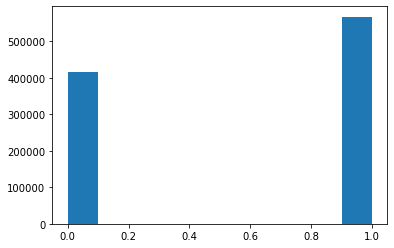

In [11]:
plt.hist(y_pred_xg)

In [21]:
y_pred_xg_proba = model_xgboost.predict_proba(X_test)

In [23]:
convert_to_pickle(model_xgboost, 'Inputs/model_xgboost')

In [27]:
y_pred_xg_proba, y_pred_xg

y_new = y_pred_xg_proba[:,1]
y_new

array([0.50686157, 0.5304707 , 0.5238733 , ..., 0.5017609 , 0.5609101 ,
       0.50689864], dtype=float32)

(array([5.00000e+00, 3.00000e+00, 1.00000e+00, 7.00000e+00, 2.30000e+01,
        4.00000e+01, 6.60000e+01, 1.13000e+02, 1.31000e+02, 1.92000e+02,
        2.69000e+02, 3.81000e+02, 5.60000e+02, 7.87000e+02, 1.17500e+03,
        1.68700e+03, 2.29400e+03, 3.36800e+03, 5.50400e+03, 1.11060e+04,
        2.03800e+04, 3.48950e+04, 6.95730e+04, 1.35785e+05, 2.79414e+05,
        2.53458e+05, 8.56340e+04, 3.26960e+04, 1.55470e+04, 8.73800e+03,
        5.41500e+03, 3.52500e+03, 2.47400e+03, 1.72800e+03, 1.22100e+03,
        8.78000e+02, 7.39000e+02, 5.35000e+02, 3.95000e+02, 3.04000e+02,
        2.14000e+02, 1.59000e+02, 1.35000e+02, 1.07000e+02, 7.50000e+01,
        5.10000e+01, 4.10000e+01, 3.80000e+01, 3.90000e+01, 9.00000e+00]),
 array([0.10912198, 0.12475786, 0.14039375, 0.15602964, 0.17166553,
        0.18730143, 0.2029373 , 0.2185732 , 0.23420909, 0.24984497,
        0.26548088, 0.28111675, 0.29675263, 0.31238854, 0.32802442,
        0.3436603 , 0.3592962 , 0.37493208, 0.39056796, 0.406203

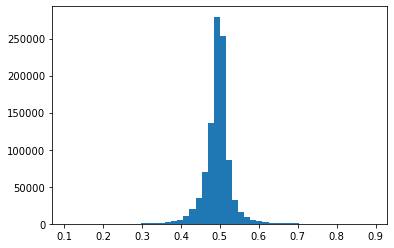

In [24]:
plt.hist(y_pred_xg_proba[:,0], bins = 50)

In [21]:
MAE_error = mean_absolute_error(y_train, y_pred_train)
print('Train data Mean Absolute Error is {}'.format(MAE_error))

MAE_error = mean_absolute_error(y_test, y_pred)
print('Test data Mean Absolute Error is {}'.format(MAE_error))

Train data Mean Absolute Error is 0.4318003204652639
Test data Mean Absolute Error is 0.4882382774866231


In [22]:
y_test

1408577    0
1408578    0
1408579    0
1408580    1
1408581    0
          ..
2390486    1
2390487    0
2390488    1
2390489    0
2390490    0
Name: action, Length: 981914, dtype: category
Categories (2, int64): [0, 1]

# Use the predicted action to find the sharpe of the data

In [28]:
#Running for full data at once
#y_pred_df,y_test = create_action(0, y_pred, y_test, test_date, test_weight)
Pi_list = []
y_pred_df = pd.DataFrame(y_pred_xg, columns = ['action'], index = test_date)

for date in y_pred_df.index.unique():
    today = y_pred_df[y_pred_df.index == date]
    today_test = test[test.date == date]
    
    Pi = return_per_day(np.array(today_test['resp']), np.array(today_test['weight']), np.array(today['action']))
    Pi_list.append(Pi)


sharpe, util_score = sharpe_score(Pi_list)
print("Sharpe is :" + str(sharpe)) 
print("Utility Score is :" + str(util_score) )

Sharpe is :-0.7414656217747798
Utility Score is :-0.0


In [ ]:
MLP Regressor 
Sharpe is :1.644709071733926
Utility Score is :559.5978351003276
    
XGBoost action predictor - Here if we see the predict proba ..the values are all around 0.49 and 0.55 , this means the model is too sensitive for small chnages in the values. 
So we need to dampen the data such that we can vary the threshold and still the output would not vary a lot 
Sharpe is :2.699589401656477
Utility Score is :1873.4041631767134
    


In [33]:
np.random.randn(-0.4,0.4)

TypeError: 'float' object cannot be interpreted as an integer

(array([3.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00,
        2.00000e+00, 1.00000e+00, 4.00000e+00, 1.00000e+00, 4.00000e+00,
        5.00000e+00, 6.00000e+00, 1.10000e+01, 8.00000e+00, 1.00000e+01,
        2.10000e+01, 2.60000e+01, 2.80000e+01, 3.20000e+01, 4.90000e+01,
        4.80000e+01, 4.20000e+01, 7.70000e+01, 8.20000e+01, 1.05000e+02,
        1.28000e+02, 1.97000e+02, 2.34000e+02, 2.76000e+02, 3.41000e+02,
        4.49000e+02, 5.76000e+02, 7.33000e+02, 9.72000e+02, 1.20500e+03,
        1.59300e+03, 2.15500e+03, 3.00600e+03, 4.00800e+03, 5.95700e+03,
        9.25200e+03, 1.42650e+04, 2.42050e+04, 4.66280e+04, 1.10955e+05,
        3.35294e+05, 2.35888e+05, 8.07340e+04, 3.84020e+04, 2.08960e+04,
        1.26400e+04, 8.18000e+03, 5.72000e+03, 4.03500e+03, 2.95400e+03,
        2.09600e+03, 1.60300e+03, 1.22700e+03, 9.47000e+02, 7.31000e+02,
        5.79000e+02, 4.61000e+02, 3.96000e+02, 3.29

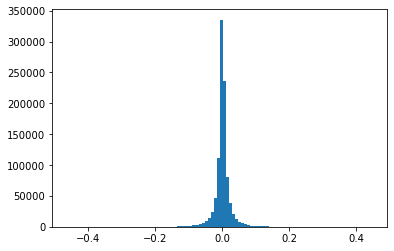

In [37]:
plt.hist(test.resp, bins = 100)

In [49]:
test.sigmoid_resp.describe()

count    981914.000000
mean          0.498884
std           0.102312
min           0.000132
25%           0.465160
50%           0.500007
75%           0.533666
max           0.999902
Name: sigmoid_resp, dtype: float64

(array([  202.,   299.,   358.,   465.,   480.,   487.,   525.,   586.,
          587.,   618.,   705.,   757.,   767.,   837.,   924.,   983.,
         1070.,  1190.,  1251.,  1311.,  1475.,  1559.,  1710.,  1863.,
         1971.,  2173.,  2382.,  2548.,  2856.,  3135.,  3406.,  3826.,
         4179.,  4836.,  5400.,  6217.,  7015.,  8072.,  9265., 10720.,
        12454., 14693., 17423., 21239., 26297., 33586., 43157., 56218.,
        74437., 92550., 93557., 76462., 58014., 44132., 33713., 26210.,
        21145., 17117., 14536., 12150., 10284.,  8847.,  7566.,  6649.,
         5782.,  5224.,  4704.,  4175.,  3741.,  3218.,  3043.,  2862.,
         2459.,  2307.,  2038.,  1860.,  1705.,  1483.,  1381.,  1343.,
         1160.,  1170.,  1078.,   992.,   911.,   838.,   753.,   736.,
          648.,   653.,   610.,   551.,   517.,   474.,   433.,   387.,
          395.,   328.,   262.,   247.]),
 array([1.32061700e-04, 1.01297651e-02, 2.01274685e-02, 3.01251719e-02,
        4.01228753e-02

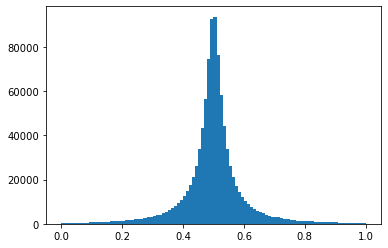

In [50]:
plt.hist(test.sigmoid_resp, bins = 100)